## First Neural Network

In [3]:
!pip install tsfresh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# If you need to plot or visualize data later on
import matplotlib.pyplot as plt
import seaborn as sns

# For any data preprocessing or manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Depending on the models you plan to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Dataset

In [6]:
fazeli_mitbih_train_df = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)

In [18]:
fazeli_mitbih_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mitbih_test.csv', header=None)

In [7]:
column_187 = fazeli_mitbih_train_df.iloc[:, 187]
column_187.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

## Comprehensive Feature Extraction

using tsfresh time series comprehensive feature extraction package

### Next cell takes 15-30 min to run

In [ ]:
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Load your dataset
fazeli_mitbih_train_df = pd.read_csv('../data/mitbih_train.csv', header=None)

# Assign a unique ID to each row and separate the target variable
fazeli_mitbih_train_df['id'] = range(len(fazeli_mitbih_train_df))
target_series = fazeli_mitbih_train_df[187]

# Keep only features and the unique ID for feature extraction
fazeli_mitbih_train_df_features_only = fazeli_mitbih_train_df.drop(columns=[187])

# Convert to long format, preserving the 'id' for direct mapping
long_df = fazeli_mitbih_train_df_features_only.melt(id_vars='id', var_name='time', value_name='amplitude')

# Define feature extraction settings
extraction_settings = ComprehensiveFCParameters()

# Incremental extraction setup
unique_ids = long_df['id'].unique()
subset_size = 10000  # Adjust based on your dataset size and memory constraints
extracted_features_list = []

for i in range(0, len(unique_ids), subset_size):
    subset_ids = unique_ids[i:i+subset_size]
    subset_df = long_df[long_df['id'].isin(subset_ids)]

    # Extract features for this subset
    subset_features = extract_features(subset_df, column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings, n_jobs=7)
    extracted_features_list.append(subset_features)



Feature Extraction:   0%|                                | 0/35 [00:00<?, ?it/s]/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Plea

Feature Extraction:   0%|                                | 0/35 [00:00<?, ?it/s]/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/ry/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Plea

In [ ]:

# Combine extracted features from all subsets
extracted_features = pd.concat(extracted_features_list)

# Re-associate the target labels using the 'id' column
# This step correctly maps the original labels to the extracted features based on 'id'
extracted_features['label'] = extracted_features.index.map(lambda idx: target_series.loc[idx])

# Verify the re-association of labels
print(extracted_features[['label']].head())


   label
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0


In [ ]:
column_187_extracted = extracted_features['label']
column_187_extracted.value_counts()

label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

## Set X and y from extracted features, Perform train_test_split

In [ ]:
# Setting X and y from my extracted features
X = extracted_features.drop('label', axis=1)
y = extracted_features['label']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# WIP Neural Network

In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy}")



548/548 - 1s - loss: 0.0623 - accuracy: 0.9837 - 1s/epoch - 2ms/step
Test Accuracy: 0.9837245345115662


548/548 [==============================] - 1s 2ms/step


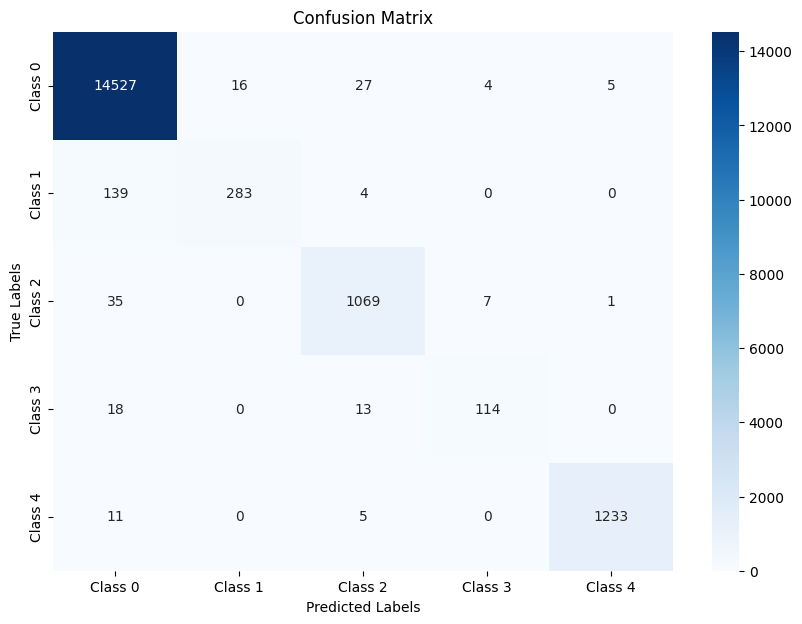

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the classes with the model
predictions = model.predict(X_test)

# Convert predictions from one-hot encoded vectors to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels from one-hot encoded vectors to class labels
true_labels = np.argmax(y_test, axis=1)

# Now you can compute the confusion matrix and plot it as previously described
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

# Assuming your input shape is (timesteps, features)
input_shape = (187, 1)  # Adjusted input shape to match your dataset

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 183, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 91, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 91, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 44, 128)           0

In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
2189/2189 [==============================] - 16s 5ms/step - loss: 0.4301 - accuracy: 0.8802 - val_loss: 0.2590 - val_accuracy: 0.9272
Epoch 2/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.2541 - accuracy: 0.9300 - val_loss: 0.2095 - val_accuracy: 0.9407
Epoch 3/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.2117 - accuracy: 0.9406 - val_loss: 0.1713 - val_accuracy: 0.9485
Epoch 4/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1876 - accuracy: 0.9476 - val_loss: 0.1489 - val_accuracy: 0.9556
Epoch 5/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1692 - accuracy: 0.9517 - val_loss: 0.1395 - val_accuracy: 0.9603
Epoch 6/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1561 - accuracy: 0.9564 - val_loss: 0.1250 - val_accuracy: 0.9633
Epoch 7/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1436 - accuracy: 0.9600 - val_loss: 0.1104 - val_ac

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where to save the model
    monitor='val_loss',
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs if necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add ModelCheckpoint to the callbacks list
)


Epoch 1/100
2180/2189 [============================>.] - ETA: 0s - loss: 0.1183 - accuracy: 0.9681
Epoch 1: val_loss improved from inf to 0.09765, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1184 - accuracy: 0.9681 - val_loss: 0.0976 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 2/100
  39/2189 [..............................] - ETA: 8s - loss: 0.1191 - accuracy: 0.9696

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2181/2189 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9690
Epoch 2: val_loss improved from 0.09765 to 0.09134, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1125 - accuracy: 0.9690 - val_loss: 0.0913 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 3/100
2181/2189 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9703
Epoch 3: val_loss did not improve from 0.09134
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1087 - accuracy: 0.9704 - val_loss: 0.0951 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9714
Epoch 4: val_loss improved from 0.09134 to 0.08341, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1039 - accuracy: 0.9714 - val_loss: 0.0834 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 5/100
2186/2189 [============================>.] - ETA: 0

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# Assuming your input shape is (timesteps, features)
input_shape = (187, 1)  # Adjusted input shape to match your dataset

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),  # Batch Normalization layer after Convolution
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),  # Another Batch Normalization layer
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),  # And another one
    GlobalAveragePooling1D(),

    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 183, 64)           384       
                                                                 
 batch_normalization (Batch  (None, 183, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 91, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 91, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 89, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 89, 128)          

In [16]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where to save the model
    monitor='val_loss',
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs if necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add ModelCheckpoint to the callbacks list
)


Epoch 1/100
2183/2189 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.9287
Epoch 1: val_loss improved from inf to 0.15190, saving model to best_model.h5
2189/2189 [==============================] - 18s 7ms/step - loss: 0.2580 - accuracy: 0.9287 - val_loss: 0.1519 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 2/100
  19/2189 [..............................] - ETA: 13s - loss: 0.1197 - accuracy: 0.9655

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2185/2189 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9583
Epoch 2: val_loss did not improve from 0.15190
2189/2189 [==============================] - 14s 6ms/step - loss: 0.1516 - accuracy: 0.9584 - val_loss: 0.1894 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 3/100
2186/2189 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9650
Epoch 3: val_loss improved from 0.15190 to 0.10350, saving model to best_model.h5
2189/2189 [==============================] - 15s 7ms/step - loss: 0.1280 - accuracy: 0.9650 - val_loss: 0.1035 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 4/100
2182/2189 [============================>.] - ETA: 0s - loss: 0.1175 - accuracy: 0.9677
Epoch 4: val_loss improved from 0.10350 to 0.09959, saving model to best_model.h5
2189/2189 [==============================] - 15s 7ms/step - loss: 0.1175 - accuracy: 0.9677 - val_loss: 0.0996 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/100
2186/2189 [============================>.] - ETA: 0

In [19]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming the last column is the label
X_test_df = fazeli_mitbih_test_df.iloc[:, :-1].values
y_test_df = fazeli_mitbih_test_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements
X_test_reshaped = X_test_df.reshape((X_test_df.shape[0], X_test_df.shape[1], 1))

# Convert y to categorical if your model's output is categorical
y_test_categorical = to_categorical(y_test_df)

# Evaluate the model on the separate test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


685/685 [==============================] - 2s 3ms/step - loss: 0.0649 - accuracy: 0.9846
Test Loss: 0.06490693241357803
Test Accuracy: 0.9845605492591858
